# Credit Card Fraud Detection Project

## Overview

This project investigated the credit card fraud detection.

## Import Packages

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix 
from sklearn.metrics import roc_auc_score, roc_curve, auc
#import geopandas as gpd

In [3]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## API
https://www.fraudlabspro.com/developer

In [91]:
from order import Order

f = open('api.json')
api_key = json.load(f)

df_order = pd.DataFrame()
for i in range(5):
    d = { 'key': api_key,
          'ip': '19{}.112.62.101'.format(i)}

    result = json.loads(Order.validate(d))
    df_order = pd.concat([df_order, pd.DataFrame(result, index=[0])])
    time.sleep(0.1)

In [89]:
df_order

,is_country_match,is_high_risk_country,distance_in_km,distance_in_mile,ip_country,ip_continent,ip_region,ip_city,ip_latitude,ip_longitude,...,user_order_memo,fraudlabspro_score,fraudlabspro_distribution,fraudlabspro_status,fraudlabspro_id,fraudlabspro_version,fraudlabspro_error_code,fraudlabspro_message,fraudlabspro_credits,device_id
0,NA,N,-,-,AR,South America,Cordoba,Las Varillas,-31.87208,-62.71946,...,,100,0,APPROVE,20210107-H1WDDP,1.5.1,208,INVALID QUANTITY VALUE,498,NA
0,NA,N,-,-,CL,South America,Region Metropolitana de Santiago,Santiago,-33.42628,-70.56656,...,,100,0,APPROVE,20210107-LFVKXT,1.5.1,208,INVALID QUANTITY VALUE,498,NA
0,NA,N,-,-,US,North America,California,Tustin,33.73617,-117.82073,...,,100,0,APPROVE,20210107-P8FPTC,1.5.1,208,INVALID QUANTITY VALUE,498,NA
0,NA,N,-,-,CN,Asia,Beijing,Beijing,39.9075,116.39723,...,,100,0,APPROVE,20210107-71TGP5,1.5.1,208,INVALID QUANTITY VALUE,498,NA
0,NA,N,-,-,GB,Europe,England,London,51.50853,-0.12574,...,,100,0,APPROVE,20210107-QBJ5OX,1.5.1,208,INVALID QUANTITY VALUE,498,NA


## Exploratory Data Analysis
This step is to understand the information contained within the data. Become familiar with the data. Data visualizations is created to determine if there are any relationships between the features and the target variables. Look to see if there are any extreme values.

In [19]:
df = pd.read_excel('data/default_of_credit_card_clients.xls', header=1)

In [20]:
df.rename(columns={'default payment next month': 'Class'}, inplace=True)

In [23]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Class
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [109]:
# remove the name column
# df = df[df.index != 18381]

# # cast the remaining columns to int
# df = df.astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         29999 non-null  int64
 1   LIMIT_BAL  29999 non-null  int64
 2   SEX        29999 non-null  int64
 3   EDUCATION  29999 non-null  int64
 4   MARRIAGE   29999 non-null  int64
 5   AGE        29999 non-null  int64
 6   PAY_0      29999 non-null  int64
 7   PAY_2      29999 non-null  int64
 8   PAY_3      29999 non-null  int64
 9   PAY_4      29999 non-null  int64
 10  PAY_5      29999 non-null  int64
 11  PAY_6      29999 non-null  int64
 12  BILL_AMT1  29999 non-null  int64
 13  BILL_AMT2  29999 non-null  int64
 14  BILL_AMT3  29999 non-null  int64
 15  BILL_AMT4  29999 non-null  int64
 16  BILL_AMT5  29999 non-null  int64
 17  BILL_AMT6  29999 non-null  int64
 18  PAY_AMT1   29999 non-null  int64
 19  PAY_AMT2   29999 non-null  int64
 20  PAY_AMT3   29999 non-null  int64
 21  PAY_AMT4   2

In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [7]:
col = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',       
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']  

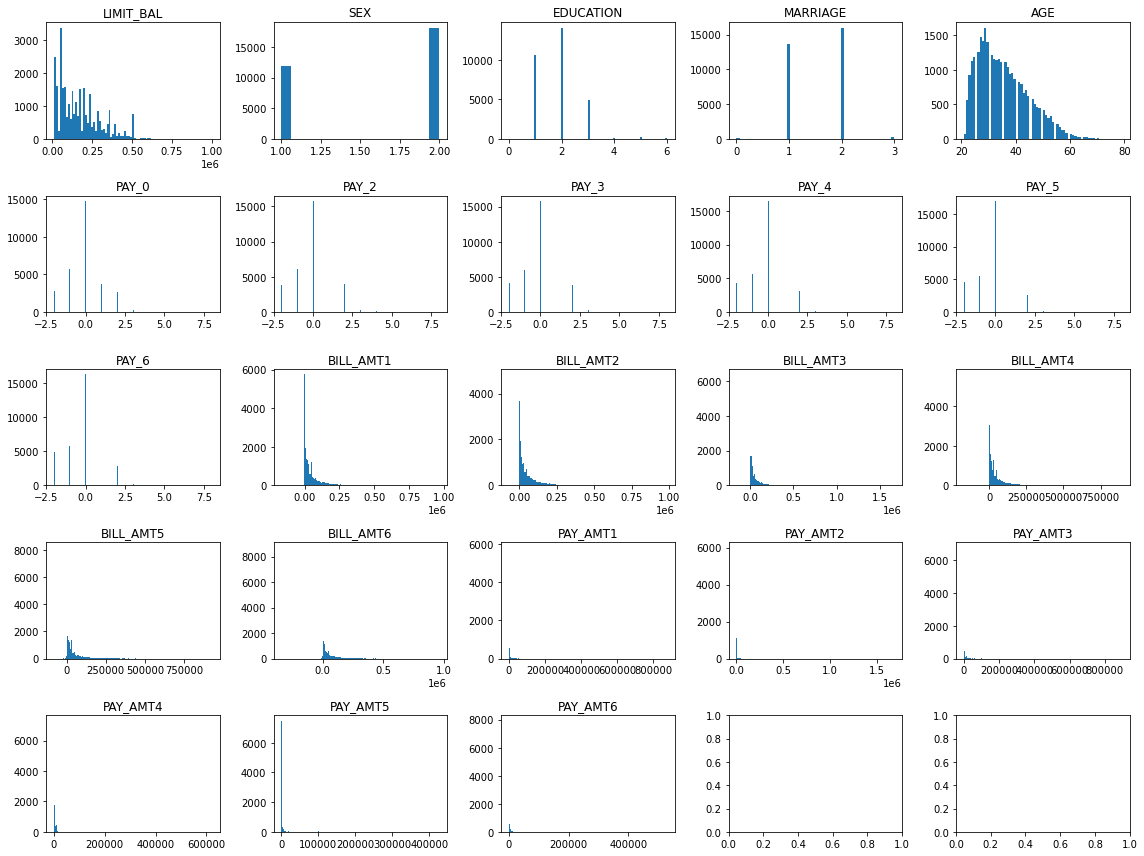

In [10]:
fig, axes = plt.subplots(5,5, figsize=(16,12))
for ax, c in zip(axes.flat, col):
    ax.hist(df[c], bins='auto')
    ax.set_title(c)
plt.tight_layout()

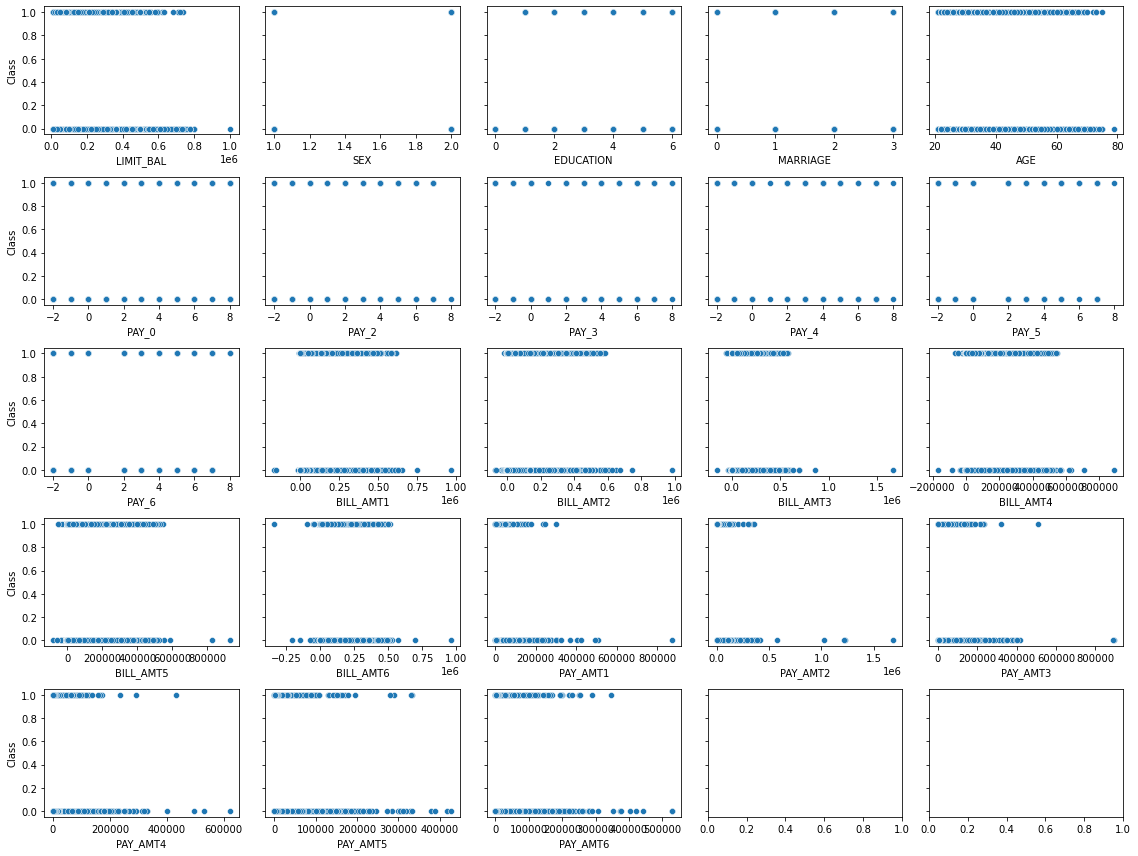

In [16]:
fig, axes = plt.subplots(5,5, sharey=True, figsize=(16,12))
for ax, c in zip(axes.flat, col):
    sns.scatterplot(data=df, x=c, y='Class', ax=ax)
plt.tight_layout()

## Class Imbalance

<AxesSubplot:xlabel='Class'>

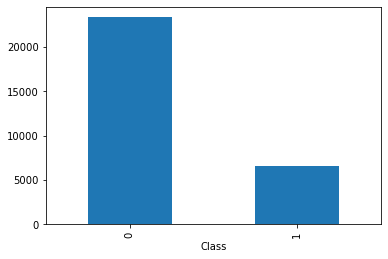

In [17]:
df.groupby(['Class']).size().plot.bar()

<AxesSubplot:>

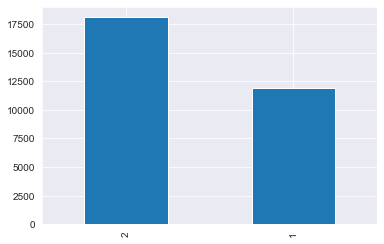

In [112]:
# which gender is which?
df.SEX.value_counts().plot(kind='bar')

In [113]:
def is_male(n):
    if n == 2:
        return 0
    else: 
        return n

df.SEX = df.SEX.apply(is_male)

# Change the column name to 'male'

df.columns = ['male' if x == 'SEX' else x for x in df.columns]

## Education

<AxesSubplot:xlabel='EDUCATION', ylabel='LIMIT_BAL'>

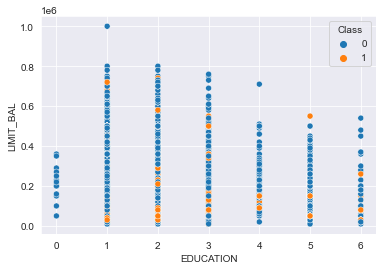

In [114]:
sns.scatterplot(data=df, x='EDUCATION', y='LIMIT_BAL', hue='Class')

Let's see what the count is for each group. There are almost no observations in any of the groups larger than 3. From the documentation, there is no evidence that there is any group other than 1,2,3,4. So Let's bin all of the 4+ into 1 category

In [115]:
df.groupby(['EDUCATION']).LIMIT_BAL.count().sort_values()#.plot(kind='bar')

EDUCATION
0       14
6       51
4      123
5      280
3     4917
1    10585
2    14029
Name: LIMIT_BAL, dtype: int64

In [116]:
# Categorize the education levels, compare all categories to high_school

def education_categories(n):
    if n > 3 or n == 0:
        return 'other'
    elif n == 3:
        return 'high_school'
    elif n == 2:
        return 'university'
    elif n == 1:
        return 'post_grad'

edu_cat = df.EDUCATION.apply(education_categories)
df.EDUCATION = edu_cat
edu_cat_dummies = pd.get_dummies(edu_cat, drop_first=True)
edu_cat_dummies

,other,post_grad,university
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
29995,0,0,0
29996,0,0,0
29997,0,0,1
29998,0,0,0


## MARRIAGE

Let's do the same for marriage status, dummy the columns. I do not know what 'other' means in this scenario. I think it is better to just bin people into either married or not married.

1='married', 2='not married'

In [117]:
df.groupby(['MARRIAGE']).LIMIT_BAL.count().sort_values()#.plot(kind='bar')

MARRIAGE
0       54
3      323
1    13658
2    15964
Name: LIMIT_BAL, dtype: int64

In [118]:
def marriage_categorization(n):
    if n == 1:
        return 'married'
    else: 
        return 'not_married'

mar_cat = df.MARRIAGE.apply(marriage_categorization)
mar_cat_dummies = pd.get_dummies(mar_cat, drop_first=True)

## LIMIT_BAL

I wonder if limit_bal is actually a continuous variable or a discrete variable. It could actually behave a little bit more like categorical data then anything else since the credit limit is determined by a lot of factors relating to a persons financial situation.

There are only 80 unique values

In [119]:
df.LIMIT_BAL.value_counts().sort_values(ascending=False)

50000      3365
20000      1976
30000      1609
80000      1567
200000     1528
           ... 
16000         2
690000        1
1000000       1
760000        1
327680        1
Name: LIMIT_BAL, Length: 81, dtype: int64

<AxesSubplot:ylabel='Frequency'>

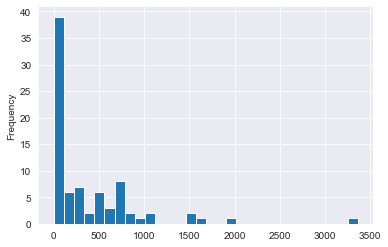

In [120]:
df.LIMIT_BAL.value_counts().sort_index(ascending=False).plot(kind='hist', bins=30)

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Class'>

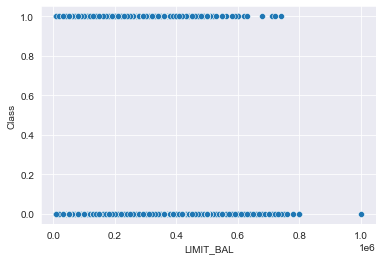

In [122]:
sns.scatterplot(data=df, x='LIMIT_BAL', y='Class')

In [24]:
default = df[df['Class'] == 1]
not_default = df[df['Class'] == 0]

stats.ttest_ind(default.LIMIT_BAL, not_default.LIMIT_BAL, equal_var=False)

NameError: name 'stats' is not defined

<AxesSubplot:xlabel='AGE', ylabel='LIMIT_BAL'>

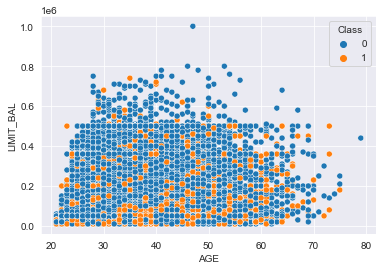

In [125]:
sns.scatterplot(data=df, x='AGE', y='LIMIT_BAL', hue='Class')

## ylim is discrete not continuous

When you zoom in, you find that there are regular intervals of every 10000. A useful metric may be the proportion of defaulters as the limit_bal increases

In [127]:
# Calculate the proportion for each stratat
def calculate_prop(df, column):
    total = df.groupby([column]).ID.count()
    defaulter = df[df['Class'] == 1].groupby([column]).ID.count()
    proportion = defaulter/total
    return proportion

proportion = calculate_prop(df, 'LIMIT_BAL')
proportion = proportion.replace(np.nan, 0)

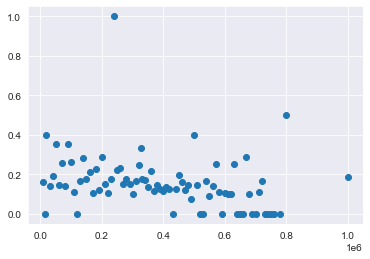

In [128]:
plt.scatter(df.LIMIT_BAL.unique(), proportion)

<AxesSubplot:ylabel='Frequency'>

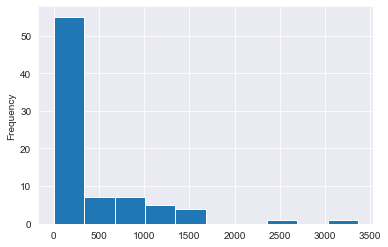

In [129]:
credit_limit_categories = pd.cut(df.LIMIT_BAL, 80)
credit_limit_categories
df['limit_cat_10'] = credit_limit_categories
df.groupby(['limit_cat_10']).ID.count().plot(kind='hist')

In [131]:
# categorize based on IQR
df.LIMIT_BAL.describe()

def limit_bal_tocat(n):
    if n <= 50000:
        return 'low'
    elif  n <= 140000:
        return 'low_mid'
    elif n <= 240000:
        return 'high_mid'
    else:
        return 'high'
    
df['limit_cat'] = df.LIMIT_BAL.apply(limit_bal_tocat)

default = df[df['Class'] ==1]
non_default = df[df['Class'] ==0]
limit_cat_dummies = pd.get_dummies(df.limit_cat)

## Payment

f in any given month the payment is on time, the month has a -1. Let's sum up all of the value accross the data frame as a measure of delinquency

In [133]:
pay = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

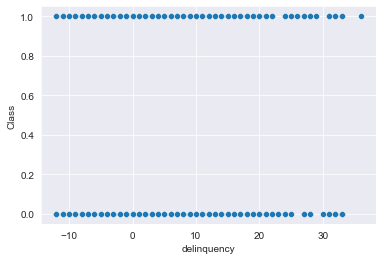

In [135]:
# sum the payments accross the columns
delinquency  = df[pay].sum(axis=1)
df['delinquency'] = delinquency
sns.scatterplot(data=df, x='delinquency', y='Class', x_jitter=3, y_jitter=10);

In [ ]:
stats.ttest_ind(df[df['Class']==1].delinquency, df[df['Class']==0].delinquency, equal_var=False)

<AxesSubplot:xlabel='delinquency', ylabel='Count'>

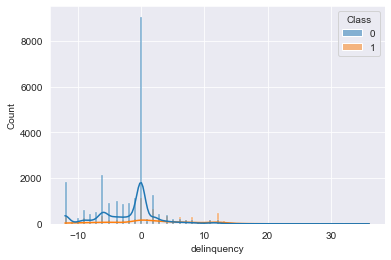

In [137]:
sns.histplot(data=df, x='delinquency', hue='Class', kde=True)

In [26]:
df[bills]

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
...,...,...,...,...,...,...
29995,188948,192815,208365,88004,31237,15980
29996,1683,1828,3502,8979,5190,0
29997,3565,3356,2758,20878,20582,19357
29998,-1645,78379,76304,52774,11855,48944


In [25]:
bills = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

account_balance = df.LIMIT_BAL-df[bills].sum(axis=1) + df[payments].sum(axis=1)
df['account_balance'] = account_balance

# credit utility
df['credit_utility'] = df['account_balance']/df.LIMIT_BAL*100

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

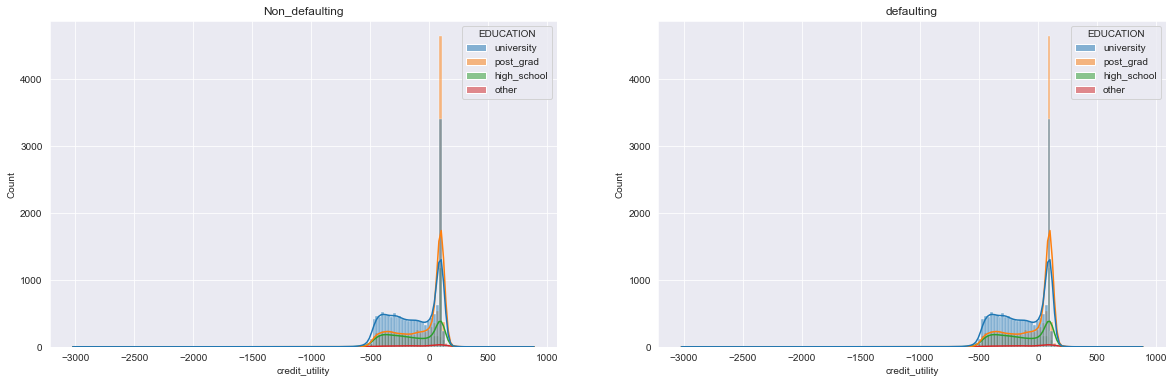

In [140]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax1.set_title('Non_defaulting')

ax2 = fig.add_subplot(122)
ax2.set_title('defaulting')

g1 = sns.histplot(data=df['Class'] == 0, x=df['credit_utility'], hue=df['EDUCATION'],kde=True, ax=ax1)
g2 = sns.histplot(data=df['Class'] == 1, x=df['credit_utility'], hue=df['EDUCATION'],kde=True, ax=ax2);

sns.color_palette("hls", 8)

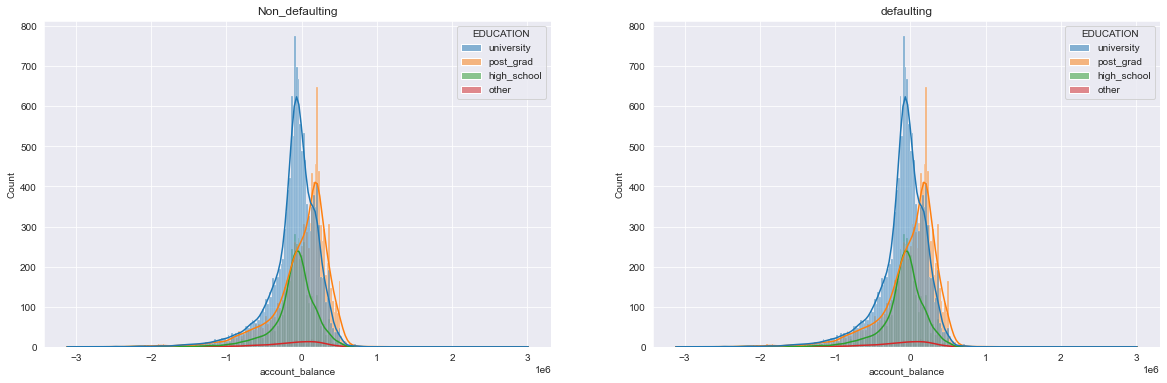

In [142]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax1.set_title('Non_defaulting')

ax2 = fig.add_subplot(122)
ax2.set_title('defaulting')
g1 = sns.histplot(data=df[df['Class'] == 0], x=df['account_balance'], hue=df['EDUCATION'],kde=True, ax=ax1)
g2 = sns.histplot(data=df[df['Class'] == 1], x=df['account_balance'], hue=df['EDUCATION'],kde=True, ax=ax2);

sns.color_palette("hls", 8)

In [150]:
df = pd.get_dummies(df, columns=['EDUCATION'], prefix='EDU', drop_first=True)

In [158]:
df = pd.get_dummies(df, columns=['limit_cat'], prefix='cat', drop_first=True)

In [160]:
df.head()

,ID,LIMIT_BAL,male,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,limit_cat_10,delinquency,account_balance,credit_utility,EDU_other,EDU_post_grad,EDU_university,cat_high_mid,cat_low,cat_low_mid
0,1,20000,0,1,24,2,2,-1,-1,-2,...,"(9010.0, 22375.0]",-2,12985,64.925000,0,0,1,0,1,0
1,2,120000,0,2,26,-1,2,0,0,0,...,"(109000.0, 121375.0]",3,107923,89.935833,0,0,1,0,0,1
2,3,90000,0,2,34,0,0,0,0,0,...,"(84250.0, 96625.0]",0,-635,-0.705556,0,0,1,0,0,1
3,4,50000,0,1,37,0,0,0,0,0,...,"(47125.0, 59500.0]",0,-172946,-345.892000,0,0,1,0,1,0
4,5,50000,1,1,57,-1,0,-1,0,0,...,"(47125.0, 59500.0]",-2,-290,-0.580000,0,0,1,0,1,0


# Modeling

In [159]:
df.columns

Index(['ID', 'LIMIT_BAL', 'male', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Class', 'limit_cat_10',
       'delinquency', 'account_balance', 'credit_utility', 'EDU_other',
       'EDU_post_grad', 'EDU_university', 'cat_high_mid', 'cat_low',
       'cat_low_mid'],
      dtype='object')

In [161]:
col = ['LIMIT_BAL', 'male', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
       'delinquency', 'account_balance', 'credit_utility', 'EDU_other',
       'EDU_post_grad', 'EDU_university', 'cat_high_mid', 'cat_low',
       'cat_low_mid']

In [162]:
X = df[col]
y = df.Class

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34)

In [92]:
from imblearn.over_sampling import SMOTE ADASYN

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

In [108]:
# adasyn = ADASYN()
# X_train, y_train = adasyn.fit_sample(X_train, y_train)

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [164]:
#lr = LogisticRegression()
lr = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
lr.fit(X_train, y_train)

train_pred_lr = lr.predict(X_train)
test_pred_lr = lr.predict(X_test)

In [165]:
train_accu_lr = accuracy_score(y_train, train_pred_lr)
test_accu_lr = accuracy_score(y_test, test_pred_lr)

print('Training accuracy score: {}'.format(train_accu_lr))
print('Test accuracy score: {}'.format(test_accu_lr))

Training accuracy score: 0.7800346682074759
Test accuracy score: 0.7749333333333334


In [166]:
train_f1_lr = f1_score(y_train, train_pred_lr)
test_f1_lr = f1_score(y_test, test_pred_lr)

print('Training F1 score: {}'.format(train_f1_lr))
print('Test F1 score: {}'.format(test_f1_lr))

Training F1 score: 0.0
Test F1 score: 0.0


In [167]:
y_score = lr.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [168]:
 print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6603109703115199


In [104]:
sns.set_style('darkgrid')

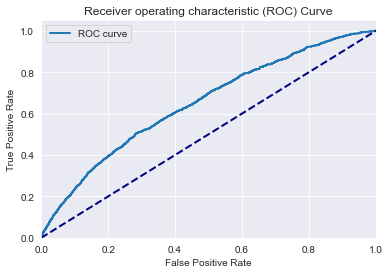

In [107]:
plt.plot(fpr, tpr, lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], c='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend()

## K-Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

train_pred_knn = knn.predict(X_train)
test_pred_knn = knn.predict(X_test)

In [97]:
train_accu_knn = accuracy_score(y_train, train_pred_knn)
test_accu_knn = accuracy_score(y_test, test_pred_knn)

print('Training accuracy score: {}'.format(train_accu_knn))
print('Test accuracy score: {}'.format(test_accu_knn))

Training accuracy score: 0.8449565912725611
Test accuracy score: 0.6101333333333333


In [98]:
train_f1_knn = f1_score(y_train, train_pred_knn)
test_f1_knn = f1_score(y_test, test_pred_knn)

print('Training F1 score: {}'.format(train_f1_knn))
print('Test F1 score: {}'.format(test_f1_knn))

Training F1 score: 0.8601674179008371
Test F1 score: 0.37627986348122866


## Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [112]:
tree = DecisionTreeClassifier(max_depth=4, criterion='entropy')
tree.fit(X_train, y_train)

train_pred_tree = tree.predict(X_train)
test_pred_tree = tree.predict(X_test)

In [113]:
train_accu_tree = accuracy_score(y_train, train_pred_tree)
test_accu_tree = accuracy_score(y_test, test_pred_tree)

print('Training accuracy score: {}'.format(train_accu_tree))
print('Test accuracy score: {}'.format(test_accu_tree))

Training accuracy score: 0.7149303175691113
Test accuracy score: 0.7081333333333333


In [114]:
train_f1_tree = f1_score(y_train, train_pred_tree)
test_f1_tree = f1_score(y_test, test_pred_tree)

print('Training F1 score: {}'.format(train_f1_tree))
print('Test F1 score: {}'.format(test_f1_tree))

Training F1 score: 0.7112358250404998
Test F1 score: 0.48287266713914473


## Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

train_pred_rf = rf.predict(X_train)
test_pred_rf = rf.predict(X_test)

In [171]:
train_accu_rf = accuracy_score(y_train, train_pred_rf)
test_accu_rf = accuracy_score(y_test, test_pred_rf)

print('Training accuracy score: {}'.format(train_accu_rf))
print('Test accuracy score: {}'.format(test_accu_rf))

Training accuracy score: 0.9995555358015912
Test accuracy score: 0.8184


In [172]:
train_f1_rf = f1_score(y_train, train_pred_rf)
test_f1_rf = f1_score(y_test, test_pred_rf)

print('Training F1 score: {}'.format(train_f1_rf))
print('Test F1 score: {}'.format(test_f1_rf))

Training F1 score: 0.9989888776541962
Test F1 score: 0.4895052473763119


## SVM 

In [33]:
from sklearn.svm import SVC

In [105]:
svm = SVC()
svm.fit(X_train, y_train)

train_pred_svm = svm.predict(X_train)
test_pred_svm = svm.predict(X_test)

In [106]:
train_accu_svm = accuracy_score(y_train, train_pred_svm)
test_accu_svm = accuracy_score(y_test, test_pred_svm)

print('Training accuracy score: {}'.format(train_accu_svm))
print('Test accuracy score: {}'.format(test_accu_svm))

Training accuracy score: 0.6269705277587388
Test accuracy score: 0.5801333333333333


In [107]:
train_f1_svm = f1_score(y_train, train_pred_svm)
test_f1_svm = f1_score(y_test, test_pred_svm)

print('Training F1 score: {}'.format(train_f1_svm))
print('Test F1 score: {}'.format(test_f1_svm))

Training F1 score: 0.650187466523835
Test F1 score: 0.4134848202644813


## XGBoost

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [29]:
from sklearn.pipeline import Pipeline

In [30]:
pipe = Pipeline([('ss', StandardScaler()), ('xgb', XGBClassifier())])
                 
param_grid = {'xgb__criterion': ['gini', "entropy"],    
              'xgb__learning_rate': [1],
              'xgb__max_depth': [4],
              'xgb__max_features': [None,4],
              'xgb__min_child_weight': [1, 2],
              'xgb__subsample': [0.5],
              'xgb__min_samples_split': [10],
              'xgb__min_samples_leaf': [6],
              'xgb__n_estimators': [100]}


grid_xgb = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

/Users/mbcn345/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                       

In [45]:
print(classification_report(y_test, test_pred_lr))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5856
           1       0.00      0.00      0.00      1644

    accuracy                           0.78      7500
   macro avg       0.39      0.50      0.44      7500
weighted avg       0.61      0.78      0.68      7500



In [46]:
accuracy_score(y_test, test_pred_lr)

0.7806666666666666

In [47]:
f1_score(y_test, test_pred_lr)

0.0

In [48]:
confusion_matrix(y_test, test_pred_lr)

array([[5855,    1],
       [1644,    0]])

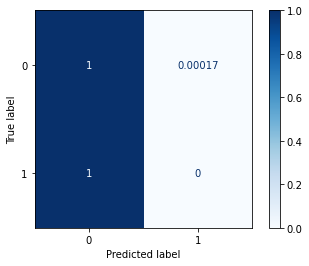

In [56]:
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Blues, normalize='true')                              

# Visualization

# Conclusion